In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import cross_validation

import seaborn as sns
sns.set()
sns.set(style="whitegrid")

c:\users\boris\documents\scikit-learn-master\sklearn\cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Загрузим данные

In [164]:
#dbname = 'speech_train'
dbname = 'Liberman M Emotional Prosody Speech and Transcripts'
#dbname = 'Emo-DB'
#db = pd.read_csv("speech/" + dbname, usecols=["class","F0mean","F0std","Shimmer","Jitter","HFEnergy"])
db = pd.read_csv("speech/" + dbname + ".csv")

db = db.dropna()

#valueCols = ["F0Mean","F0Std","Shimmer","Jitter","HFEnergy", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", "M10", "M11", "M12", "M13", "M14", "M15", "M16"]
#valueCols = ["M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", "M10", "M11", "M12", "M13", "M14", "M15", "M16"]
valueCols = ["M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9"]

# Преобразуем из строки в число
#db['M1'] = db['M1'].str.replace('%','').astype(np.float64)
#db.dtypes

Извлечем метки и индексы классов из Path

In [165]:
import os
def getClassName(path):
    p = path.replace('\\', '/')    
    return os.path.basename(os.path.dirname(p))

vclassName = np.vectorize(getClassName)
db["className"] = vclassName(db["Path"])

le = preprocessing.LabelEncoder()
le.fit(['нейтраль', 'гнев', 'печаль', 'радость', 'страх'])
db["class"] = le.transform(db["className"].values) 

#sns.pairplot(db[valueCols + ["class"]], hue="class", diag_kind="kde", size=3, markers=['x','o','v','^','<'])
#plt.savefig('figures/' + dbname + '_pairplot.png')

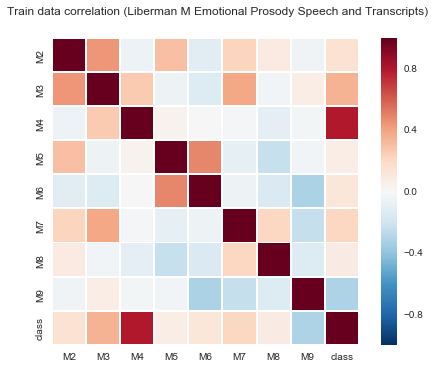

In [166]:
# Set up the matplotlib figure
f, ax = plt.subplots()

sns.heatmap(db[valueCols+ ["class"]].corr(), ax=ax, square=True, linewidths=1)
plt.gcf().suptitle('Train data correlation (' + dbname + ')')
plt.savefig('figures/' + dbname + '_train_correlation.png')

## Подготовка данных для классификатора

In [171]:
# Перешаем датасет
db = db.reindex(np.random.permutation(db.index))

# Получим нужные данные в массив
x_train = db[valueCols].values

# Нормализуем входные данные
x_train = (x_train - x_train.mean()) / (x_train.max() - x_train.min())

y_train_raw = db[['class']].values.ravel()



y_train = []
for y in y_train_raw:
    if y == 0:
        y_train.append([1,0,0,0])
    if y == 1:
        y_train.append([0,0,0,0])
    if y == 2:
        y_train.append([0,1,0,0])
    if y == 3:
        y_train.append([0,0,1,0])
    if y == 4:
        y_train.append([0,0,1,0])
    
y_train = np.array(y_train)    

#db[['Path','className', 'class']].values

lb = preprocessing.LabelBinarizer()
lb.fit(y_train_raw)
#y_train = lb.transform(y_train_raw)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

## Настроим классификатор

В качестве классификатора - многослойный персептрон

In [172]:
from sklearn.neural_network import MLPClassifier

# algs: l-bfgs, sgd, adam
# actiovation: tanh, logistic, relu
clf = MLPClassifier(activation='tanh', 
                    algorithm='l-bfgs', 
                    hidden_layer_sizes=(100,100), 
                    max_iter=1000, 
                    random_state=1, 
                    tol = 0.000001,
                    alpha = 0.000001,
                    learning_rate_init=0.05, 
                    learning_rate='adaptive')

clf.fit(x_train, y_train)

MLPClassifier(activation='tanh', algorithm='l-bfgs', alpha=1e-06,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100, 100),
       learning_rate='adaptive', learning_rate_init=0.05, max_iter=1000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, tol=1e-06, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [173]:
# Кросс-валидация
cv = cross_validation.ShuffleSplit(len(y_train), n_iter=10, test_size=0.3, random_state=0)
scores = cross_validation.cross_val_score(clf, x_train, y_train, cv=cv)
print("Точность классификатора: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

Точность классификатора: 0.81 (+/- 0.19)
[ 0.8125   0.9375   0.84375  0.8125   0.8125   0.75     0.875    0.71875
  0.90625  0.59375]


c:\users\boris\documents\scikit-learn-master\sklearn\metrics\ranking.py:541: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


2

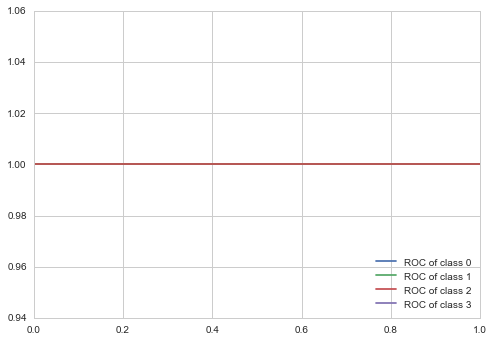

In [214]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

plt.clf()
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])

nclasses = y_train.shape[1]
precision = dict()
recall = dict()
#fpr = dict()
#tpr = dict()
y_score = clf.predict_proba(x_train)
#y_score = clf.decision_function(x_train)
for i in range(nclasses):
    #precision[i], recall[i], _ = precision_recall_curve(y_train[:, i], y_score[:, i])
    #plt.plot(recall[i], precision[i], label='Precision-recall curve of class ' + str(i))
    fpr, tpr, _ = roc_curve(y_train[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label='ROC of class ' + str(i))

#plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
#
#precision_recall_curve(y_train[:,0], predicted[:,0])
y

## Вычислим класс для каждой записи из экспериментов

In [ ]:
#name = "reading"
#name = "reading-splitted"
#name = "plasticity"
name = "Liberman M Emotional Prosody Speech and Transcripts"
#name = "Emo-DB"
test = pd.read_csv('speech/' + name + ".csv")
test = test.dropna()
test_data = test[valueCols]

test_norm = (test_data - test_data.mean()) / (test_data.max() - test_data.min())
test_data.head()

In [ ]:
res = clf.predict_log_proba(test_norm.values)
#res

In [ ]:
predicted = res.argmin(axis=1)
predicted

In [ ]:
def clname(x): return classes[x]
cl = np.vectorize(clname)

test['PredictedClass']=predicted
test['PredictedClassName']=cl(predicted)

In [ ]:
test.to_csv('speech/' + name + '_predicted.csv', index_label="id")
#sns.pairplot(test[valueCols + ['predicted_class']], hue="predicted_class", diag_kind="kde", size=3, markers=['x','o','v','^','<'])
#plt.savefig('figures/' + name + '.pairplot.png')

corr = test[valueCols+ ["PredictedClass"]].corr()
f, ax = plt.subplots()
sns.heatmap(corr, ax=ax, square=True, linewidths=1)
plt.gcf().suptitle(name + ' correlation (predicted)')
plt.savefig('figures/' + name + '_predicted_correlation.png')
corr.to_csv('speech/' + name + '_predicted_correlation.csv')

# Предскажем класс по тесту Reading в самих результатах

In [ ]:
results = pd.read_csv('valid_results.csv')
results = results.dropna()
results_data = results[valueCols]
results_data = (results_data - results_data.mean()) / (results_data.max() - results_data.min())

In [ ]:
predicted = clf.predict_log_proba(results_data.values).argmin(axis=1)
predicted

In [ ]:
results['ReadingClass'] = predicted
results['ReadingClassName']=cl(predicted)

corr = results[valueCols+ ["ReadingClass"]].corr()
f, ax = plt.subplots()
sns.heatmap(corr, ax=ax, square=True, linewidths=1)
plt.gcf().suptitle('Predicted results correlation')
plt.savefig('figures/valid_results_predicted.correlation.png')

results.to_csv('valid_results_predicted.csv', index=False, encoding='utf8')